In [17]:
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
# Set random seed for reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ================= DATA LOADING =================
X_all = np.load("X_train_all.npy")  # (22400, 180) input sinyal
y_all = np.load("y_train_all.npy")  # (22400,) labels

# Pastikan data dalam format yang benar
X_all = X_all.astype("float32")  # Sinyal
y_all = y_all.astype("int64")    # Labels

# Add channel dimension if necessary
if X_all.ndim == 2:  # Misalnya [22400, 180] -> [22400, 180, 1]
    X_all = np.expand_dims(X_all, axis=2)

# Normalize the data if necessary
if X_all.max() > 1.0:
    X_all = X_all / 255.0

X_tensor = torch.from_numpy(X_all)  # [22400, 180, 1]
y_tensor = torch.from_numpy(y_all)  # [22400,]
num_classes = int(np.unique(y_all).size)

In [4]:
# ================= MODEL: Transformer Encoder-Decoder =================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


class TransformerEncoderDecoder(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_encoder_layers=3,
                 num_decoder_layers=2, dim_feedforward=256, dropout=0.1, num_classes=5, max_len=200):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)  # Linear Projection
        self.pos_enc = PositionalEncoding(d_model, max_len)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Learned BOS token for decoder start
        self.bos_token = nn.Parameter(torch.randn(1, 1, d_model))  # [1, 1, d_model]

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, L, C = x.shape  # [B, L, C] -> Batch size, Length, Channel
        x = self.input_proj(x)  # [B, L, d_model] -> [B, L, d_model]
        x = self.pos_enc(x)     # Add positional encoding

        # Encoder output: [B, L, d_model]
        memory = self.encoder(x)  # [B, L, d_model]

        # Create the target for the decoder (BOS token as input)
        tgt = self.bos_token.expand(B, 1, -1)  # [B, 1, d_model] -> token BOS for decoder
        
        # Pass to the decoder
        out = self.decoder(tgt=tgt, memory=memory)  # [B, 1, d_model]

        # Squeeze output for final prediction [B, d_model]
        out = out.squeeze(1)  # [B, d_model]
        out = self.norm(out)  # [B, d_model]

        logits = self.head(out)  # [B, num_classes]
        return logits


In [5]:
# ================= TRAINING =================
def run_epoch(model, loader, criterion, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if xb.ndim == 2:
            xb = xb.unsqueeze(2)

        if train_mode:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)

        # Append predictions and true labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds)

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc, y_true, y_pred



In [6]:
# ================= K-FOLD TRAINING =================
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 64
num_epochs = 20
save_dir = "checkpoints_transformer_encoder_decoder"
os.makedirs(save_dir, exist_ok=True)

all_hist = []
per_class_metrics = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor), 1):
    print(f"\n========== Fold {fold}/5 ==========")
    X_tr, y_tr = X_tensor[train_idx], y_tensor[train_idx]
    X_va, y_va = X_tensor[val_idx], y_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_va, y_va), batch_size=batch_size, shuffle=False)

    model = TransformerEncoderDecoder(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch(model, val_loader, criterion, None, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accuracies.append(tr_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best for this fold (based on val acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()

    # restore best & save model fold
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), os.path.join(save_dir, f"transformer_fold{fold}.pth"))
    print(f"✅ Model saved: {os.path.join(save_dir, f'transformer_fold{fold}.pth')}")

    # ------------- Evaluasi final per fold (pakai best model) -------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels_b in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels_b.numpy())

    # Report & Confusion Matrix
    report = classification_report(y_true, y_pred, output_dict=True,
                                   target_names=["N", "S", "V", "Q"], zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Specificity per-class: TN / (TN + FP)
    cm_sum = cm.sum()
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm_sum - (TP + FP + FN)
    specificity_per_class = TN / (TN + FP + 1e-8)

    # Save per-class metrics
    for i, cname in enumerate(["N", "S", "V", "Q"]):
        per_class_metrics.append({
            "Fold": f"Fold {fold}",
            "Class": cname,
            "Precision": report[cname]["precision"],
            "Sensitivity": report[cname]["recall"],
            "Specificity": specificity_per_class[i],
            "F1-Score": report[cname]["f1-score"]
        })

    # Fold summary metrics
    fold_summary = {
        "Fold": fold,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "Specificity": specificity_per_class.mean(),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
    }

    fold_metrics.append(fold_summary)

    # ----------------- Save visuals (per fold) -----------------
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_confusion_matrix_fold{fold}.png"))
    plt.close(fig)

    # Accuracy curve
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Accuracy - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_accuracy_fold{fold}.png"))
    plt.close()

    # Loss curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_loss_fold{fold}.png"))
    plt.close()

# ================= SIMPAN TABEL RINGKASAN =================
df_folds = pd.DataFrame(fold_metrics)
df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics.csv"), index=False)

# ================= SIMPAN TABEL PER KELAS =================
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

print("\n✅ Semua model, grafik, dan metrik Transformer Encoder-Decoder disimpan di folder:", save_dir)

# ---------------------------
# 7. Hitung Rata-rata Metrik per Fold
# ---------------------------
df_fold = pd.DataFrame(fold_metrics)

# Menghitung rata-rata dari metrik yang diinginkan per fold
avg_metrics = df_fold[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"]].mean(numeric_only=True)

# Menambahkan baris 'Average' ke DataFrame
avg_row = {"Fold": "Average"}
avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)

# Menyimpan hasil summary fold dan rata-rata
df_fold.to_csv(os.path.join(save_dir, "fold_summary_metrics_with_average.csv"), index=False)

# ---------------------------
# 8. Simpan Tabel Metrik Per Kelas
# ---------------------------
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

print("\n✅ Semua model, grafik, dan metrik Transformer Encoder-Decoder disimpan di folder:", save_dir)



========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.4957 Acc: 0.7965 | Val Loss: 0.2764 Acc: 0.9058
Epoch 02/20 | Train Loss: 0.2363 Acc: 0.9206 | Val Loss: 0.2144 Acc: 0.9288
Epoch 03/20 | Train Loss: 0.2029 Acc: 0.9324 | Val Loss: 0.1907 Acc: 0.9417
Epoch 04/20 | Train Loss: 0.1775 Acc: 0.9433 | Val Loss: 0.1603 Acc: 0.9482
Epoch 05/20 | Train Loss: 0.1682 Acc: 0.9445 | Val Loss: 0.1532 Acc: 0.9502
Epoch 06/20 | Train Loss: 0.1514 Acc: 0.9496 | Val Loss: 0.1610 Acc: 0.9498
Epoch 07/20 | Train Loss: 0.1477 Acc: 0.9518 | Val Loss: 0.1664 Acc: 0.9473
Epoch 08/20 | Train Loss: 0.1394 Acc: 0.9552 | Val Loss: 0.1699 Acc: 0.9377
Epoch 09/20 | Train Loss: 0.1502 Acc: 0.9512 | Val Loss: 0.1872 Acc: 0.9444
Epoch 10/20 | Train Loss: 0.1353 Acc: 0.9552 | Val Loss: 0.1566 Acc: 0.9522
Epoch 11/20 | Train Loss: 0.1259 Acc: 0.9580 | Val Loss: 0.1384 Acc: 0.9594
Epoch 12/20 | Train Loss: 0.1266 Acc: 0.9575 | Val Loss: 0.1448 Acc: 0.9549
Epoch 13/20 | Train Loss: 0.1240 Acc: 0.9605 | Val Loss:

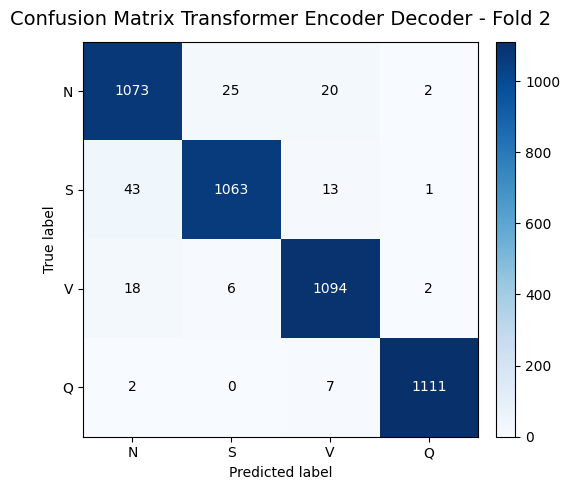

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "checkpoints_transformer_encoder_decoder"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Fold 2)
cm = np.array([
    [1073,  25,  20,   2],  # True N
    [  43, 1063, 13,   1],  # True S
    [  18,   6, 1094,  2],  # True V
    [   2,   0,   7, 1111]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Transformer Encoder Decoder - Fold 2', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)


# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan ke folder checkpoints_transformer_encoder_decoder
out_path = os.path.join(save_dir, 'transformer_encoder_decoder_nontuning_confusionmatrix_fold2.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
EXTERNAL TEST

Evaluasi External Test Set Encoder Decoder: 100%|██████████| 88/88 [00:00<00:00, 266.25it/s]



=== Evaluasi pada External Test Set Transformer Encoder Decoder ===
              precision    recall  f1-score   support

           N   0.835199  0.959286  0.892952      1400
           S   0.970228  0.791429  0.871755      1400
           V   0.936770  0.973571  0.954816      1400
           Q   0.995699  0.992143  0.993918      1400

    accuracy                       0.929107      5600
   macro avg   0.934474  0.929107  0.928360      5600
weighted avg   0.934474  0.929107  0.928360      5600



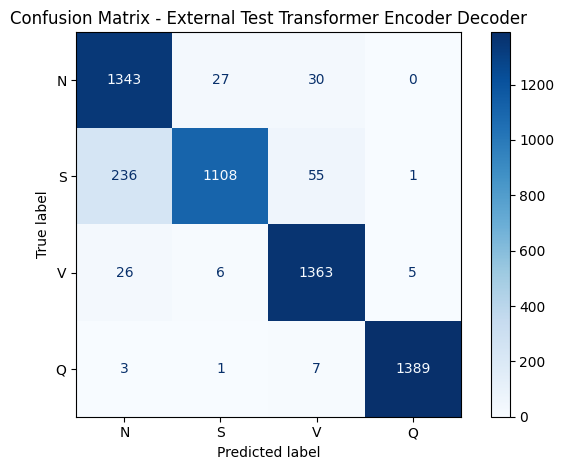

Confusion matrix disimpan ke: transformer_external_outputs/confusion_matrix_external_transformer.png

=== Ringkasan Evaluasi (External Test Set) ===
Accuracy   : 0.929107
Precision  : 0.934474
Sensitivity: 0.929107
Specificity: 0.976369
F1-Score   : 0.928360

CSV disimpan:
- transformer_external_outputs/external_summary_metrics.csv
- transformer_external_outputs/external_per_class_metrics.csv
AUC Macro  : 0.989233
AUC Micro  : 0.992213


In [15]:
import os, time, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
from tqdm import tqdm

# ====== Config ======
BATCH_SIZE    = 64
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH     = "checkpoints_transformer_encoder_decoder/transformer_fold2.pth"   # fold terbaik
X_SIG_PATH    = "X_test_final.npy"  # Sinyal input test
Y_LABEL_PATH  = "y_test_final.npy"  # Label test

OUT_DIR       = "transformer_external_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_transformer.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics.csv")

# ====== Load External Test Set ======
X_signal = np.load(X_SIG_PATH)  # (N, L) atau (N, L, 1)
y_label = np.load(Y_LABEL_PATH)

# Normalisasi (misal: skala ke [0,1] bila di luar range)
if X_signal.max() > 1.0 or X_signal.min() < 0.0:
    gmax, gmin = X_signal.max(), X_signal.min()
    if gmax != gmin:
        X_signal = (X_signal - gmin) / (gmax - gmin)

# Konversi ke tensor
X_signal_t = torch.tensor(X_signal, dtype=torch.float32)
y_label_t = torch.tensor(y_label, dtype=torch.long)

# Pastikan data sinyal memiliki dimensi [N, L, 1]
if X_signal_t.ndim == 2:
    X_signal_t = X_signal_t.unsqueeze(2)  # [N, L] -> [N, L, 1]

test_ds = TensorDataset(X_signal_t, y_label_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ====== Model: Transformer Encoder-Decoder ======
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        # Memindahkan positional encoding ke perangkat yang sama dengan input x
        return x + self.pe[:, :x.size(1)].to(x.device)  # .to(x.device) memastikan posisi berada di device yang sama dengan x


class TransformerEncoderDecoder(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_encoder_layers=3,
                 num_decoder_layers=2, dim_feedforward=256, dropout=0.1, num_classes=4, max_len=200):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)  # Proyeksi input sinyal
        self.pos_enc = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.bos_token = nn.Parameter(torch.randn(1, 1, d_model))  # Token untuk decoder
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, L, C = x.shape
        x = self.input_proj(x)  # [B, L, d_model]
        x = self.pos_enc(x)     # [B, L, d_model]

        memory = self.encoder(x)  # Output dari encoder [B, L, d_model]
        tgt = self.bos_token.expand(B, 1, -1)  # Target untuk decoder [B, 1, d_model]

        out = self.decoder(tgt=tgt, memory=memory)  # Output dari decoder [B, 1, d_model]
        out = out.squeeze(1)  # Mengubah menjadi [B, d_model]
        out = self.norm(out)  # Normalisasi
        logits = self.head(out)  # Output akhir [B, num_classes]
        return logits

# ====== Load checkpoint (STRICT) ======
model = TransformerEncoderDecoder(num_classes=NUM_CLASSES).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()

# ====== Evaluate ======
all_preds, all_labels, all_logits = [], [], []
inference_times = []

with torch.no_grad():
    for signal, labels in tqdm(test_loader, desc="Evaluasi External Test Set Encoder Decoder"):
        signal, labels = signal.to(DEVICE), labels.to(DEVICE)

        t0 = time.perf_counter()
        logits = model(signal)
        t1 = time.perf_counter()

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        inference_times.append((t1 - t0) / signal.size(0))

# Menggabungkan hasil
all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n=== Evaluasi pada External Test Set Transformer Encoder Decoder ===")
print(report_txt)
with open(SAVE_REPORT, "w") as f:
    f.write(report_txt)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix - External Test Transformer Encoder Decoder")
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150)
plt.show()
print(f"Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

print("\n=== Ringkasan Evaluasi (External Test Set) ===")
print(f"Accuracy   : {acc:.6f}")
print(f"Precision  : {prec:.6f}")
print(f"Sensitivity: {rec:.6f}")
print(f"Specificity: {spec_mean:.6f}")
print(f"F1-Score   : {f1:.6f}")

# simpan CSV
summary_df = pd.DataFrame([{
    "Accuracy": acc, "Precision": prec, "Sensitivity": rec,
    "Specificity": float(spec_mean), "F1-Score": f1,
    "AvgInference(s/sample)": float(np.mean(inference_times)) if inference_times else np.nan
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

percls_df = pd.DataFrame({
    "Class": CLASS_NAMES,
    "Precision": [precision_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)],
    "Sensitivity": [recall_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)],
    "Specificity": spec_per_cls,
    "F1-Score": [f1_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)]
})
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\nCSV disimpan:\n- {SAVE_SUMMARY}\n- {SAVE_PERCLS}")

# ====== ROC-AUC ======
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"AUC Macro  : {auc_macro:.6f}")
    print(f"AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print("ROC AUC Calculation failed:", e)

# ====== Size & Memory ======
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
except Exception:
    cpu_mem_mb = float('nan')

try:
    import GPUtil
    gpu_mem_mb = GPUtil.getGPUs()[0].memoryUsed if torch.cuda.is_available() else 0
except Exception:
    gpu_mem_mb = 0

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
